In [1]:
import pandas as pd

In [2]:
columns = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']
data = pd.read_csv("../data/2023w4.csv", usecols=columns)

In [3]:
data.columns = data.columns.str.replace(" ", "_").str.lower()

In [4]:
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [5]:
data.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [6]:
data['engine_hp'].fillna(0, inplace=True)
data['engine_cylinders'].fillna(0, inplace=True)

In [7]:
data.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [8]:
data['msrp'].value_counts()

msrp
2000     1036
29995      19
25995      19
20995      16
27995      16
         ... 
18855       1
22575       1
20050       1
26965       1
50920       1
Name: count, Length: 6049, dtype: int64

In [9]:

mean = data['msrp'].mean()
data['above_average'] = data['msrp'].apply(lambda x : 1 if x > mean else 0)

In [10]:
data['above_average'].value_counts()

above_average
0    8645
1    3269
Name: count, dtype: int64

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [24]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# df_train_full, df_test = train_test_split(data, random_state=1, test_size= 0.2)
# df_train, df_val = train_test_split(df_train_full, random_state=1, test_size= 0.25)

print(f"df_train_full:  {df_train_full.shape} ,  df_test: {df_test.shape}")
print(f"df_train:  {df_train.shape} ,  df_val: {df_val.shape}")

df_train_full:  (9531, 11) ,  df_test: (2383, 11)
df_train:  (7148, 11) ,  df_val: (2383, 11)


In [25]:
df_train.size, df_val.size, df_test.size

(78628, 26213, 26213)

In [27]:
y_train = df_train['above_average']
y_val = df_val['above_average']
y_test = df_test['above_average']

In [28]:
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [29]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [26]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
df_X_train = df_train[['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',  'above_average', 'make', 'model', 'transmission_type', 'vehicle_style']]
df_y_train = df_train['above_average']

df_X_val = df_val[['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',  'above_average', 'make', 'model', 'transmission_type', 'vehicle_style']]
df_y_val = df_val['above_average']

df_X_test = df_test[['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',  'above_average', 'make', 'model', 'transmission_type', 'vehicle_style']]
df_y_test = df_test['above_average']

In [14]:
numerical_feature = df_X_train.select_dtypes(include=["int64", "float64"]).columns.to_list()
categorical_feature = df_X_train.select_dtypes(include="object").columns.to_list()

print(f"numerical_feature : {numerical_feature}")
print(f"categorical_feature : {categorical_feature}")

numerical_feature : ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'above_average']
categorical_feature : ['make', 'model', 'transmission_type', 'vehicle_style']


In [15]:
# Calculate ROC AUC Score

from sklearn.metrics import roc_auc_score

for feature in numerical_feature :
    auc = roc_auc_score(df_y_train, df_X_train[feature])
    if auc < 0.5 :
        auc = roc_auc_score(df_y_train, -df_X_train[feature])
    print('%9s, %.3f' % (feature, auc))

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673
above_average, 1.000


Answer for Question1: = engine_hp

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [30]:
def train(df_train, y_train, C=1.0):
    dv = DictVectorizer(sparse = False)

    train_dicts = df_train.to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [31]:
dv, model = train(df_train, y_train)

In [32]:
def predict(df, dv, model):
    df_dicts = df.to_dict(orient='records')
    X = dv.transform(df_dicts)
    y_pred = model.predict(X)
    return y_pred

In [33]:
y_pred = predict(df_val, dv, model)

In [34]:
auc = roc_auc_score(y_val, y_pred)

In [35]:
round(auc, 3)

0.919

Answer for Question2: = 0.878

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [36]:
import numpy as np
thresholds = np.linspace(0, 1, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [37]:
actual_positive = y_val == 1
actual_negative = y_val != 1

In [38]:
actual_positive.shape

(2383,)

In [39]:
actual_positive.sum(), actual_negative.sum()

(654, 1729)

In [40]:
def predict_probability(df, dv, model):
    df_dicts = df.to_dict(orient='records')
    X = dv.transform(df_dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [41]:
y_pred = predict_probability(df_val, dv, model)

In [42]:
y_pred.shape

(2383,)

In [43]:
scores = []

for t in thresholds:
    predict_positive = y_pred >= t
    predict_negative = y_pred < t
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    score = (t, tp, tn, fp, fn, precision, recall)
    scores.append(score)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16584\4084783570.py:13: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [44]:
# tp, tn, fp, fn, precision, recall
columns = ['threshold', 'tp', 'tn', 'fp', 'fn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [45]:
df_scores.head()

,threshold,tp,tn,fp,fn,precision,recall
0,0.00,654,0,1729,0,0.274444,1.000000
1,0.01,652,946,783,2,0.454355,0.996942
2,0.02,651,1087,642,3,0.503480,0.995413
3,0.03,651,1158,571,3,0.532733,0.995413
4,0.04,650,1236,493,4,0.568679,0.993884


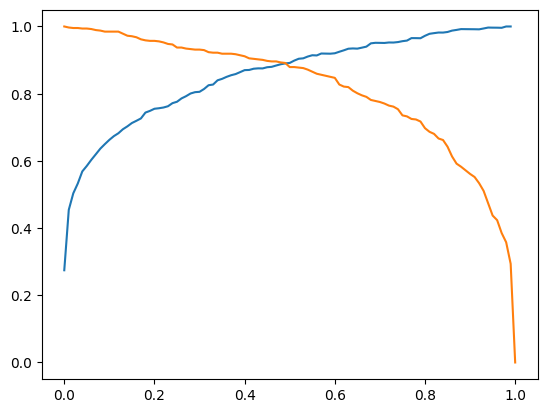

In [46]:
from matplotlib import pyplot as plt
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall')

Answer for Question3: = 0.48

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [47]:
df_scores['f1'] = (2 * df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])

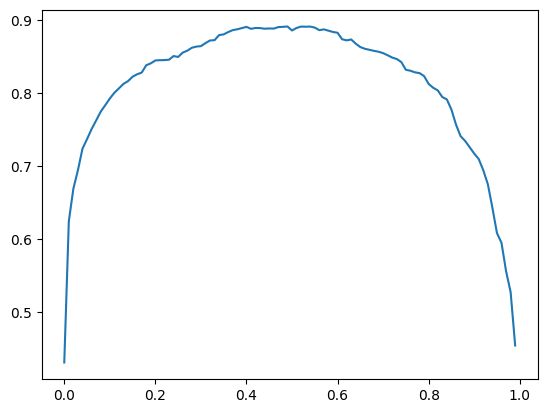

In [48]:
plt.plot(df_scores['threshold'], df_scores['f1'], label='F1 Score')

Answer for Question4 : 0.72

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

In [49]:
# Initialize kfold cross validation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [51]:
scores = []
target = 'above_average'

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    df_train = df_train.reset_index(drop=False)
    df_val = df_val.reset_index(drop=False)
    
    y_train = df_train[target]
    y_val = df_val[target]
    
    del df_train[target]
    del df_train['msrp']
    del df_val[target]
    del df_val['msrp']
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [52]:
np.std(scores)

0.012885500354165821

Answer for question 5: 0.030

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [53]:
total_scores = []
for c in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        df_train = df_train.reset_index(drop=False)
        df_val = df_val.reset_index(drop=False)

        y_train = df_train[target]
        y_val = df_val[target]

        del df_train[target]
        del df_train['msrp']
        del df_val[target]
        del df_val['msrp']

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    mean = round(np.mean(scores), 3)
    std = round(np.std(scores), 3)
    score = (c, mean, std)
    total_scores.append(score)

In [54]:
total_scores

[(0.01, 0.84, 0.004),
 (0.1, 0.867, 0.011),
 (0.5, 0.894, 0.012),
 (10, 0.887, 0.011)]

Answer for question 6: 10